<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I8kDikouqpH4hf7JBiSYAeNT2IO52T-T" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Generative adversarial networks</b></h3>



В этом домашнем задании вы обучите GAN генерировать лица людей и посмотрите на то, как можно оценивать качество генерации

In [1]:
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch
import torch.nn as nn
import cv2
from tqdm.notebook import tqdm
from torchvision.utils import save_image
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set(style='darkgrid', font_scale=1.2)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Часть 1. Подготовка данных (1 балл)

В качестве обучающей выборки возьмем часть датасета [Flickr Faces](https://github.com/NVlabs/ffhq-dataset), который содержит изображения лиц людей в высоком разрешении (1024х1024). Оригинальный датасет очень большой, поэтому мы возьмем его часть. Скачать датасет можно [здесь](https://www.kaggle.com/datasets/tommykamaz/faces-dataset-small?resource=download-directory) и  [здесь](https://drive.google.com/drive/folders/14H7LQWzd09SaM11oLfGtd455sWH2rmRW?usp=share_link)

Давайте загрузим наши изображения. Напишите функцию, которая строит DataLoader для изображений, при этом меняя их размер до нужного значения (размер 1024 слишком большой, поэтому мы рекомендуем взять размер 128 либо немного больше)

In [2]:
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from albumentations.augmentations.transforms import Normalize
from albumentations.augmentations.crops.transforms import CenterCrop
stats = {
    'mean': (0.5, 0.5, 0.5),
    'std': (0.5, 0.5, 0.5),
}

def get_dataloader(image_size, crop_size, batch_size, path):
    
    """
    Builds dataloader for training data.
    Use tt.Compose and tt.Resize for transformations
    :param image_size: height and wdith of the image
    :param batch_size: batch_size of the dataloader
    :returns: DataLoader object 
    """
    
    image_paths = os.listdir(dataset_path)
    image_processed = list()
    numpy_images = list()
    pbar = tqdm(total=len(image_paths))
    for idx, image_path in enumerate(image_paths):
        image_full_path = os.path.join(path, image_path)
        image = cv2.imread(image_full_path)
        if len(image.shape) == 2:
            image = np.vstack((image, image, image), axis=2)
        else:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        tensor_transform = A.Compose([
            CenterCrop(crop_size, crop_size, always_apply=True), 
            Normalize(**stats, always_apply=True), 
            ToTensorV2(),
        ])
        usual_transform = A.Compose([
            CenterCrop(crop_size, crop_size, always_apply=True)
        ])
        warped_image = cv2.resize(image, (image_size, image_size))
        tensor_image = tensor_transform(image=warped_image)['image']
        numpy_image = usual_transform(image=warped_image)['image']
        image_processed.append(tensor_image)
        numpy_images.append(numpy_image)
        pbar.set_description(f"Processed images: {idx}")
        pbar.update(1)
    pbar.close()
    
    return DataLoader(image_processed, shuffle=True, batch_size=batch_size), numpy_images

dataset_path = '/kaggle/input/faces-dataset-small/faces_dataset_small'
image_size = 140
crop_size = 128
batch_size = 128
loader, numpy_images = get_dataloader(
    image_size,
    crop_size,
    batch_size,
    dataset_path
)

  0%|          | 0/3143 [00:00<?, ?it/s]

## Часть 2. Построение и обучение модели (2 балла)

Сконструируйте генератор и дискриминатор. Помните, что:
* дискриминатор принимает на вход изображение (тензор размера `3 x image_size x image_size`) и выдает вероятность того, что изображение настоящее (тензор размера 1)

* генератор принимает на вход тензор шумов размера `latent_size x 1 x 1` и генерирует изображение размера `3 x image_size x image_size`

In [3]:
discriminator = nn.Sequential(
    nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1, bias=False),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),

    nn.Flatten(),
    nn.Sigmoid(),
)

In [4]:
latent_size = 128

generator = nn.Sequential(
    nn.ConvTranspose2d(latent_size, 1024, 4, 1, 0, bias=False),
    nn.BatchNorm2d(1024),
    nn.ReLU(True),

    nn.ConvTranspose2d(1024, 512, 4, 2, 1, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),

    nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    
    nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),

    nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),

    nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
    nn.Tanh(),
)

# (Hin−1)×stride[0]−2×padding[0]+(kernel_size[0]−1)+output_padding[0]+1

Перейдем теперь к обучению нашего GANа. Алгоритм обучения следующий:
1. Учим дискриминатор:
  * берем реальные изображения и присваиваем им метку 1
  * генерируем изображения генератором и присваиваем им метку 0
  * обучаем классификатор на два класса

2. Учим генератор:
  * генерируем изображения генератором и присваиваем им метку 0
  * предсказываем дискриминаторором, реальное это изображение или нет


В качестве функции потерь берем бинарную кросс-энтропию

In [5]:
lr = 0.0003
device = 'cuda' if torch.cuda.is_available() else 'cpu'

models = {
    "discriminator": discriminator,
    "generator": generator
}
for key, model in models.items():
    models[key] = model.to(device)

criterion = {
    "discriminator": nn.BCELoss(),
    "generator": nn.BCELoss()
}

In [14]:
def fit(model, criterion, epochs, lr, loader):
    import sys
    model["discriminator"].train()
    model["generator"].train()
    optimizer = dict()
    schedulers = dict()
    optimizer['discriminator'] = torch.optim.Adam(
        model['discriminator'].parameters(), lr=lr, betas=(0.5, 0.999)
    )
    optimizer['generator'] = torch.optim.Adam(
        model['generator'].parameters(), lr=lr, betas=(0.5, 0.999)
    )
    schedulers['discriminator'] = torch.optim.lr_scheduler.StepLR(
        optimizer['discriminator'],
        step_size=10,
        gamma=0.9
    )
    schedulers['generator'] = torch.optim.lr_scheduler.StepLR(
        optimizer['generator'],
        step_size=10,
        gamma=0.9
    )
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    losses_gen = list()
    losses_dis = list()
    fake_scores = list()
    real_scores = list()
    uniform_const = 0.025
    
    for epoch in range(epochs):
        loss_gen_epoch = list()
        loss_dis_epoch = list()
        real_score_epoch = list()
        fake_score_epoch = list()
        
        tepoch = tqdm(loader, unit="batch") if epoch % 5 == 0 else None
        for real_images in loader:
            # train discriminator
            optimizer["discriminator"].zero_grad()

            # pass real images
            real_images = real_images.to(device)
            real_preds = model["discriminator"](real_images)
            move_targets = torch.rand(real_images.size()[0], 1, device=device) * uniform_const
            real_targets = torch.ones(real_images.size(0), 1, device=device) - move_targets
            real_loss = criterion["discriminator"](real_preds, real_targets)
            real_score = torch.mean(real_preds).item()

            # generate fake images
            latent_batch = torch.randn(batch_size, latent_size, 1, 1, device=device)
            fake_images = model["generator"](latent_batch)

            # pass fake images
            move_targets = torch.rand(fake_images.size()[0], 1, device=device) * uniform_const
            fake_targets = torch.zeros(fake_images.size(0), 1, device=device) + move_targets
            fake_preds = model["discriminator"](fake_images)
            fake_loss = criterion["discriminator"](fake_preds, fake_targets)
            fake_score = torch.mean(fake_preds).item()

            real_score_epoch.append(real_score)
            fake_score_epoch.append(fake_score)

            # update discriminators' weights
            loss_dis = (real_loss + fake_loss) / 2
            loss_dis.backward()
            optimizer["discriminator"].step()
            loss_dis_epoch.append(loss_dis.item())

            # train generator
            optimizer["generator"].zero_grad()

            # generate fake images
            latent_batch = torch.randn(batch_size, latent_size, 1, 1, device=device)
            fake_images = model["generator"](latent_batch)

            # try to fool the discriminator
            preds = model["discriminator"](fake_images)
            targets = torch.ones(batch_size, 1, device=device)
            loss_gen = criterion["generator"](preds, targets)

            # update generators' weights
            loss_gen.backward()
            optimizer["generator"].step()
            loss_gen_epoch.append(loss_gen.item())

            if not tepoch is None:
                tepoch.set_description(f"Epoch {epoch + 1}")
                tepoch.set_postfix(loss_gen=loss_gen.item(), loss_dis=loss_dis.item(), real_score=real_score, fake_score=fake_score)
                tepoch.update(1)
        
        schedulers['generator'].step()
        schedulers['discriminator'].step()
            
        losses_gen.append(np.mean(loss_gen_epoch))
        losses_dis.append(np.mean(loss_dis_epoch))
        real_scores.append(np.mean(real_score_epoch))
        fake_scores.append(np.mean(fake_score_epoch))

    return losses_gen, losses_dis, real_scores, fake_scores

num_epoch = 100
losses_gen, losses_dis, real_scores, fake_scores = fit(models, criterion, num_epoch, lr, loader)

  0%|          | 0/25 [00:00<?, ?batch/s]

  0%|          | 0/25 [00:00<?, ?batch/s]

  0%|          | 0/25 [00:00<?, ?batch/s]

  0%|          | 0/25 [00:00<?, ?batch/s]

  0%|          | 0/25 [00:00<?, ?batch/s]

  0%|          | 0/25 [00:00<?, ?batch/s]

  0%|          | 0/25 [00:00<?, ?batch/s]

  0%|          | 0/25 [00:00<?, ?batch/s]

  0%|          | 0/25 [00:00<?, ?batch/s]

  0%|          | 0/25 [00:00<?, ?batch/s]

  0%|          | 0/25 [00:00<?, ?batch/s]

  0%|          | 0/25 [00:00<?, ?batch/s]

  0%|          | 0/25 [00:00<?, ?batch/s]

  0%|          | 0/25 [00:00<?, ?batch/s]

  0%|          | 0/25 [00:00<?, ?batch/s]

  0%|          | 0/25 [00:00<?, ?batch/s]

  0%|          | 0/25 [00:00<?, ?batch/s]

  0%|          | 0/25 [00:00<?, ?batch/s]

  0%|          | 0/25 [00:00<?, ?batch/s]

  0%|          | 0/25 [00:00<?, ?batch/s]

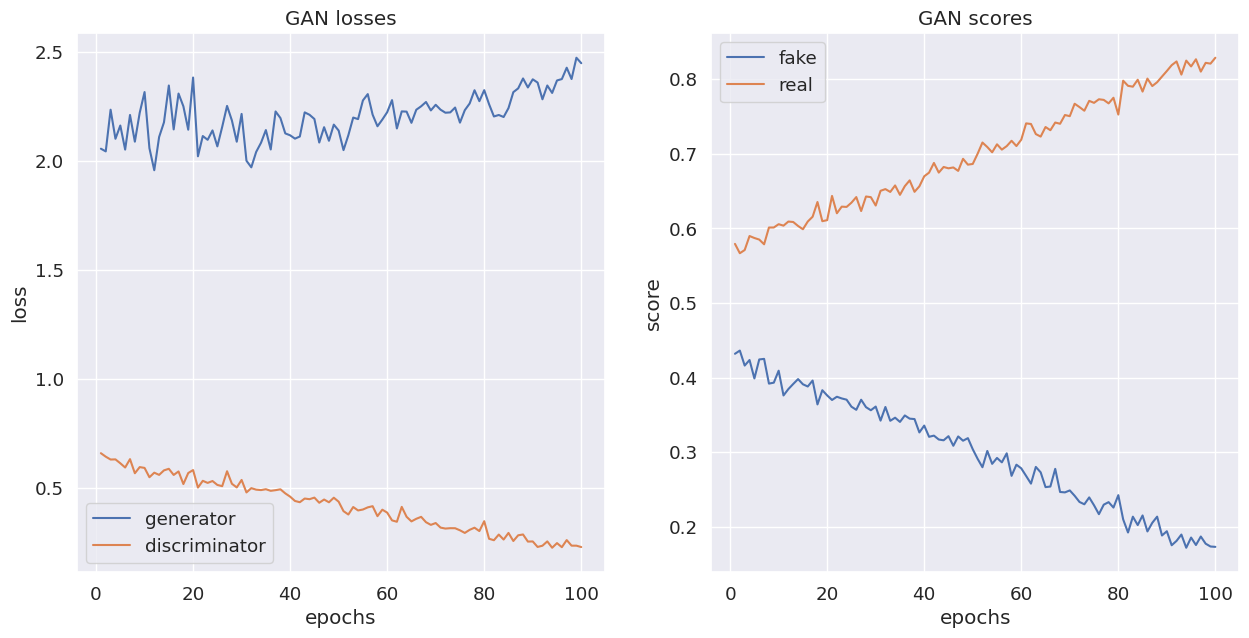

In [17]:
def plot_losses_scores(losses_gen, losses_dis, real_scores, fake_scores, num_epoch):
    fig, axes = plt.subplots(1, 2, figsize=(15, 7))
    epochs = [i + 1 for i in range(num_epoch)]
    axes[0].plot(epochs, losses_gen, label='generator')
    axes[0].plot(epochs, losses_dis, label='discriminator')
    axes[0].legend()
    axes[0].grid(True)
    axes[0].set_title('GAN losses')
    axes[0].set_xlabel('epochs')
    axes[0].set_ylabel('loss')
    
    axes[1].plot(epochs, fake_scores, label='fake')
    axes[1].plot(epochs, real_scores, label='real')
    axes[1].legend()
    axes[1].grid(True)
    axes[1].set_title('GAN scores')
    axes[1].set_xlabel('epochs')
    axes[1].set_ylabel('score')
    
    plt.show()

plot_losses_scores(losses_gen, losses_dis, real_scores, fake_scores, num_epoch)

In [6]:
mode_process = input('Load weights? (y/n)')
if mode_process == 'n':
    torch.save(models['discriminator'].state_dict(), 'discriminator_weights.pth')
    torch.save(models['generator'].state_dict(), 'generator_weights.pth')
elif mode_process == 'y':
    models['discriminator'].load_state_dict(torch.load('/kaggle/input/gan-weights/discriminator_weights.pth'))
    models['generator'].load_state_dict(torch.load('/kaggle/input/gan-weights/generator_weights.pth'))
else:
    assert mode_process in ['n', 'y']

Load weights? (y/n) y


## Часть 3. Генерация изображений (1 балл)

Теперь давайте оценим качество получившихся изображений. Напишите функцию, которая выводит изображения, сгенерированные нашим генератором

In [7]:
n_images = 8

def denormalize(from_generator):
    denormalized_images = list()
    for generated in from_generator:
        denormalized_images.append(
            generated.cpu().detach().numpy().transpose(1, 2, 0) * 0.5 + 0.5
        )
    return denormalized_images

fixed_latent = torch.randn(n_images, latent_size, 1, 1, device=device)
fake_images = models["generator"](fixed_latent)
denormalized_images = denormalize(fake_images)

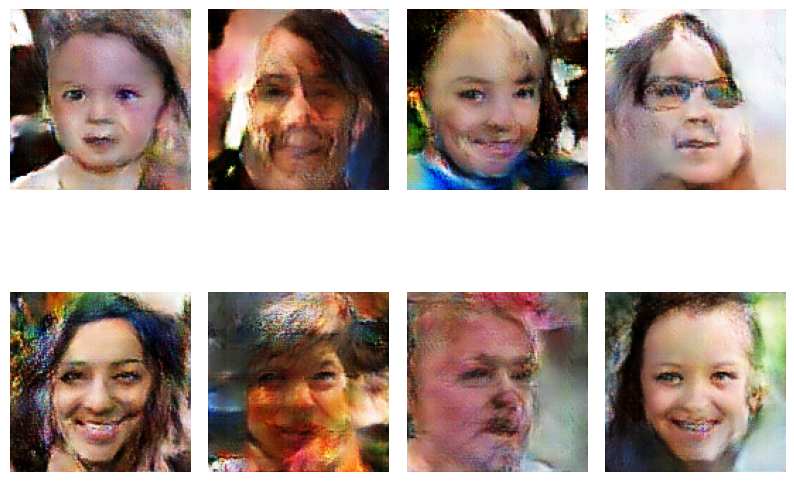

In [8]:
def show_images(generated, n_rows, n_cols, wide=0.1, height=0.1):
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 7))
    plt.subplots_adjust(wspace=wide, hspace=height)
    
    for idx, image in enumerate(generated):
        axes[idx // n_cols][idx % n_cols].imshow(image)
        axes[idx // n_cols][idx % n_cols].axis('off')

n_rows, n_cols = 2, 4
show_images(denormalized_images, n_rows, n_cols)

Как вам качество получившихся изображений?

## Часть 4. Leave-one-out-1-NN classifier accuracy (6 баллов)

### 4.1. Подсчет accuracy (4 балла)

Не всегда бывает удобно оценивать качество сгенерированных картинок глазами. В качестве альтернативы вам предлагается реализовать следующий подход:
  * Сгенерировать столько же фейковых изображений, сколько есть настоящих в обучающей выборке. Присвоить фейковым метку класса 0, настоящим – 1.
  * Построить leave-one-out оценку: обучить 1NN Classifier (`sklearn.neighbors.KNeighborsClassifier(n_neighbors=1)`) предсказывать класс на всех объектах, кроме одного, проверить качество (accuracy) на оставшемся объекте. В этом вам поможет `sklearn.model_selection.LeaveOneOut`

In [9]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import LeaveOneOut
from sklearn.manifold import TSNE

from torchvision.models import resnet101, ResNet101_Weights

resnet101_full_model = resnet101(weights=ResNet101_Weights.IMAGENET1K_V2)
modules = list(resnet101_full_model.children())[:-1]
feature_extractor = torch.nn.Sequential(*modules)
for p in feature_extractor.parameters():
    p.requires_grad = False

Downloading: "https://download.pytorch.org/models/resnet101-cd907fc2.pth" to /root/.cache/torch/hub/checkpoints/resnet101-cd907fc2.pth
100%|██████████| 171M/171M [00:00<00:00, 247MB/s] 


In [11]:
size_fake_images = len(numpy_images)
batch_size_generated = 64

generated_amount = 0
generated_images = None
while generated_amount < size_fake_images:
    fixed_latent = torch.randn(batch_size_generated, latent_size, 1, 1, device=device)
    generated_per_batch = models["generator"](fixed_latent)
    if generated_images is None:
        generated_images = generated_per_batch
    else:
        generated_images = torch.cat((generated_images, generated_per_batch), dim=0)
    
    generated_amount += batch_size_generated
    if (size_fake_images - generated_amount) > batch_size_generated:
        batch_size_generated = (size_fake_images - generated_amount)

sampled_fake_images = denormalize(generated_images)

In [31]:
def extract_features(extractor, batch_size, fake_images, real_images, device):
    
    extractor = extractor.to(device)
    
    def normalize(images, is_scale=False):
        stats = {
            'mean': (0.485, 0.456, 0.406),
            'std': (0.229, 0.224, 0.225),
        }
        image_size = 224
        tensor_transform = A.Compose([
            Normalize(**stats, always_apply=True), 
            ToTensorV2()
        ])
        
        normalized_images = list()
        for image in images:
            float_image = image.astype(np.float32)
            if is_scale:
                float_image = float_image / 255
            warped_image = cv2.resize(float_image, (image_size, image_size))
            processed_image = tensor_transform(image=warped_image)['image']
            normalized_images.append(processed_image)
            
        return DataLoader(normalized_images, batch_size=batch_size)
    
    loader_fake_images = normalize(fake_images)
    loader_real_images = normalize(real_images, is_scale=True)
    
    fake_features = None
    pbar = tqdm(len(loader_fake_images))
    for idx, fake_batch in enumerate(loader_fake_images):
        fake_batch = fake_batch.to(device)
        fake_extract_features = extractor(fake_batch).cpu().detach()
        
        if fake_features is None:
            fake_features = fake_extract_features
        else:
            fake_features = torch.cat((fake_features, fake_extract_features), dim=0)
        
        pbar.set_description(f'Batch num: {idx + 1}')
        pbar.update(1)
    pbar.close()
    
    real_features = None
    pbar = tqdm(len(loader_fake_images))
    for idx, real_batch in enumerate(loader_real_images):
        real_batch = real_batch.to(device)
        real_extract_features = extractor(real_batch).cpu().detach()
        
        if real_features is None:
            real_features = real_extract_features
        else:
            real_features = torch.cat((real_features, real_extract_features), dim=0)
        
        pbar.set_description(f'Batch num: {idx + 1}')
        pbar.update(1)
    pbar.close()
            
    return real_features, fake_features

real_features, fake_features = extract_features(
    feature_extractor, 64,
    sampled_fake_images, numpy_images,
    device
)

real_labels = torch.ones(len(real_features), dtype=torch.int64)
fake_labels = torch.zeros(len(fake_features), dtype=torch.int64)

labels = torch.cat((real_labels, fake_labels), dim=0).cpu().detach().numpy()
features = torch.squeeze(torch.cat((real_features, fake_features), dim=0)).cpu().detach().numpy()

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [66]:
loo = LeaveOneOut()
right_preds = 0
sum_preds = 0

pbar = tqdm(total=len(features))
for idx, (train_index, test_index) in enumerate(loo.split(features, labels)):
    train_features = features[train_index]
    test_sample = features[test_index]
    train_labels = labels[train_index]
    test_label = labels[test_index]
    
    knn = KNeighborsClassifier(n_neighbors = 1)
    knn.fit(train_features, train_labels)
    pred_label = knn.predict(test_sample)
    if pred_label == test_label:
        right_preds += 1
    sum_preds += 1
    
    pbar.set_description(f'iteration: {idx + 1}')
    pbar.update(1)
pbar.close()

print(f'Accuracy: {float(right_preds) / float(sum_preds)}')

  0%|          | 0/6286 [00:00<?, ?it/s]

Accuracy: 0.7281259942729876


Что вы можете сказать о получившемся результате? Какой accuracy мы хотели бы получить и почему?

Ну средне, в иделе получить около 0.5, так как это показывает, что мы не разлчиаем сгенерированные и реальные картинки

### 4.2. Визуализация распределений (2 балла)

Давайте посмотрим на то, насколько похожи распределения настоящих и фейковых изображений. Для этого воспользуйтесь методом, снижающим размерность (к примеру, TSNE) и изобразите на графике разным цветом точки, соответствующие реальным и сгенерированным изображенияи

In [ ]:
features_2d = TSNE(n_components=2).fit_transform(features)

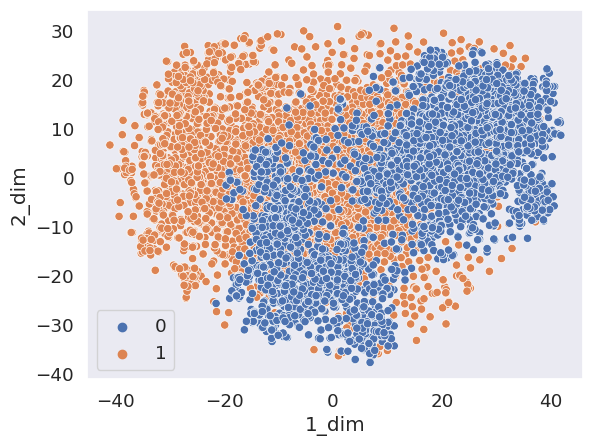

In [49]:
import seaborn as sns

def visualize_data_2d(data, labels):
    labels
    g = sns.scatterplot(x=data[:, 0], y=data[:, 1], hue=labels)
    plt.xlabel('1_dim')
    plt.ylabel('2_dim')
    plt.grid()

visualize_data_2d(features_2d, labels)

Прокомментируйте получившийся результат:

Видно, что в некоторых областях, 2 распределения (сгенерированных и реальных картинок) начинают перемешиваться, то есть эти картинки по идее друг на друга похожи, в то же время, даже визуально видно, что распределения в целом отличаются, то есть наш генератор не слшиком хорошо обучен(возможно стоило учить дольше, так как в целом прогресс наблюдается)